# Introduction

# Load & Process Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


In [ ]:
# Loads ANd processes

repo_name = 'politicalbias'
GIT_REPO = 'https://github.com/thekhan314/politicalbias.git'


from os.path import join
from google.colab import drive

BASE = 'My Drive/Colab Notebooks/'
ROOT = '/content/drive/'
PROJECT_PATH = join(ROOT,BASE)
REPO_PATH = join(PROJECT_PATH,repo_name)

drive.mount(ROOT)
%cd '{REPO_PATH}'

!pip install textdistance

from datashop_classes import *

df_adf = pd.read_csv('data/adfontes_political_bias.csv')

df_adf.head()
df_adf.info()
df_adf.describe()

def percentile_bin(score,left_percentile,right_percentile):
    if score <= left_percentile:
        return 'left'
    elif score >= right_percentile:
        return 'right'
    else:
        return "center"

left_perc = np.percentile(df_adf['article_bias'],25)
right_perc= np.percentile(df_adf['article_bias'],75)

df_adf['article_label'] = df_adf['article_bias'].apply(percentile_bin,args=(left_perc, right_perc))

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
#df_adf.head()
#df_adf.info()
#df_adf.describe()
#df_adf['article_bias'].hist()
#df_adf['label'].hist()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/politicalbias
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   article_title  3707 non-null   object 
 1   article_bias   3707 non-null   float64
 2   reliability    3707 non-null   float64
 3   article_url    3707 non-null   object 
 4   article_text   3707 non-null   object 
 5   length         3707 non-null   int64  
 6   bias           3707 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 202.9+ KB


https://medium.com/analytics-vidhya/mlforsocial-predicting-media-bias-8e94d03befb5

# EDA

## Overall Word Counts

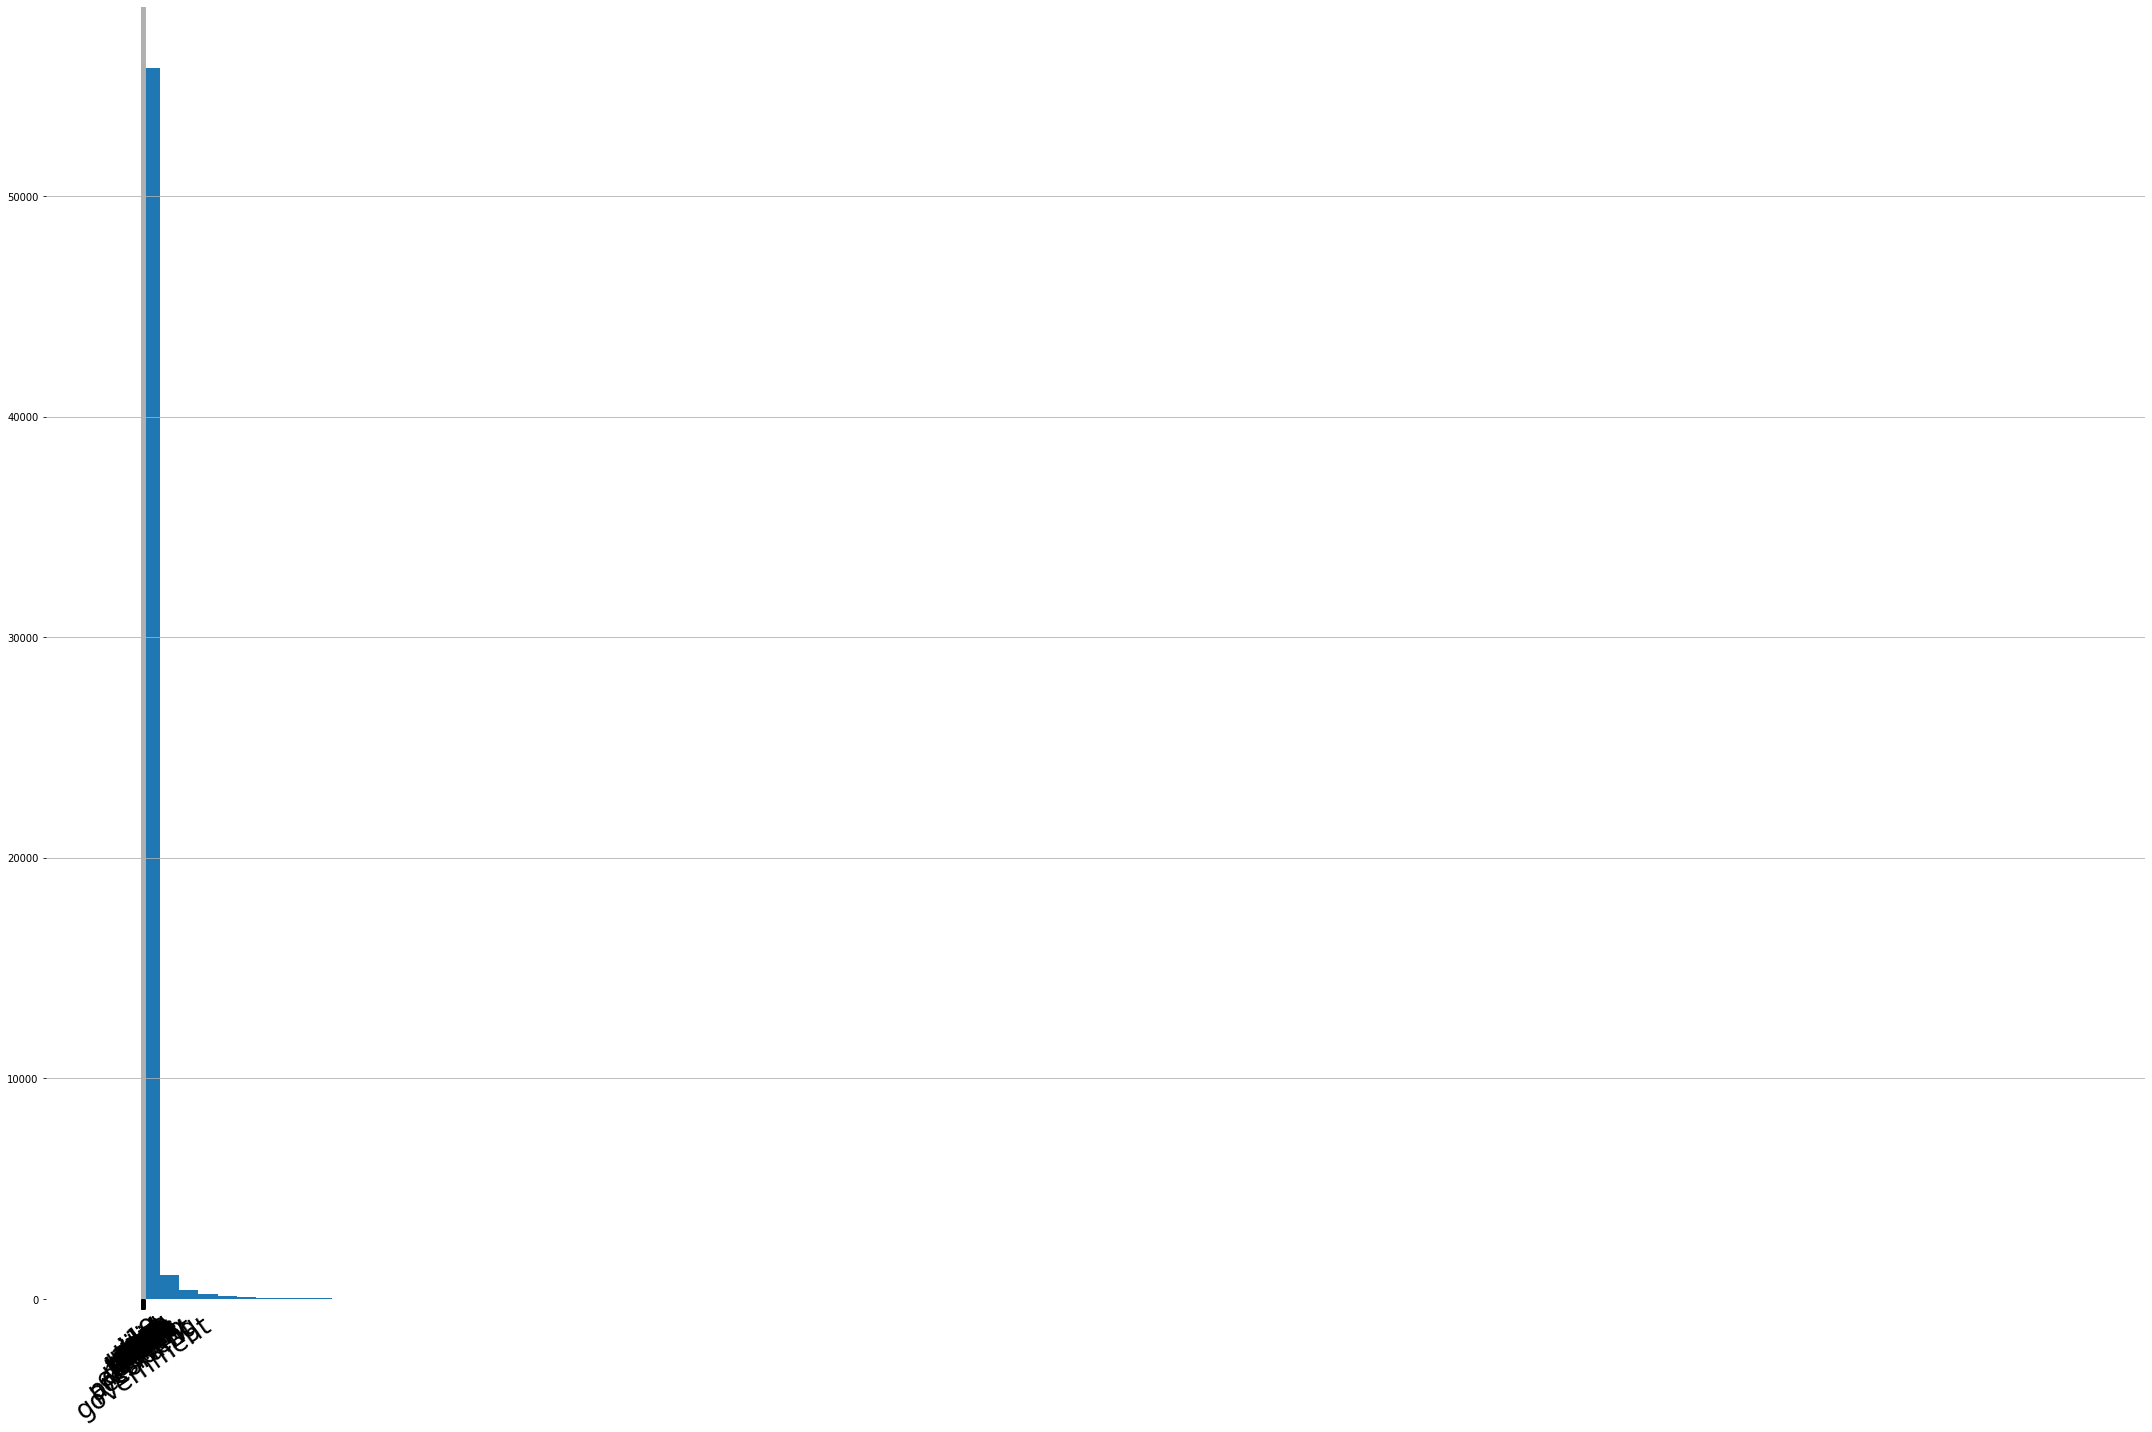

In [ ]:
all_counts = word_counts(df_adf,'article_text', show_chart=True)
all_counts.hist(bins = 100)

occur_once = all_counts[all_counts == 1]
#plot_wordcounts(occur_once.sort_values(ascending=True))

high_counts = all_counts[all_counts > 1]

#print(len(high_counts) + len(occur_once),len(all_counts))

vocab = list(high_counts.index)

## Left vs Right counts


In [ ]:
def percentile_bin(score,left_percentile,right_percentile):
    if score <= left_percentile:
        return 'left'
    elif score >= right_percentile:
        return 'right'
    else:
        return "center"

left_percentile = np.percentile(df_adf['article_bias'],25)
right_percentile= np.percentile(df_adf['article_bias'],75)

df_left = df_adf[df_adf['article_bias'] < left_percentile]
df_right = df_adf[df_adf['article_bias'] > right_percentile]

#df_left.info()
#df_right.info()

31174

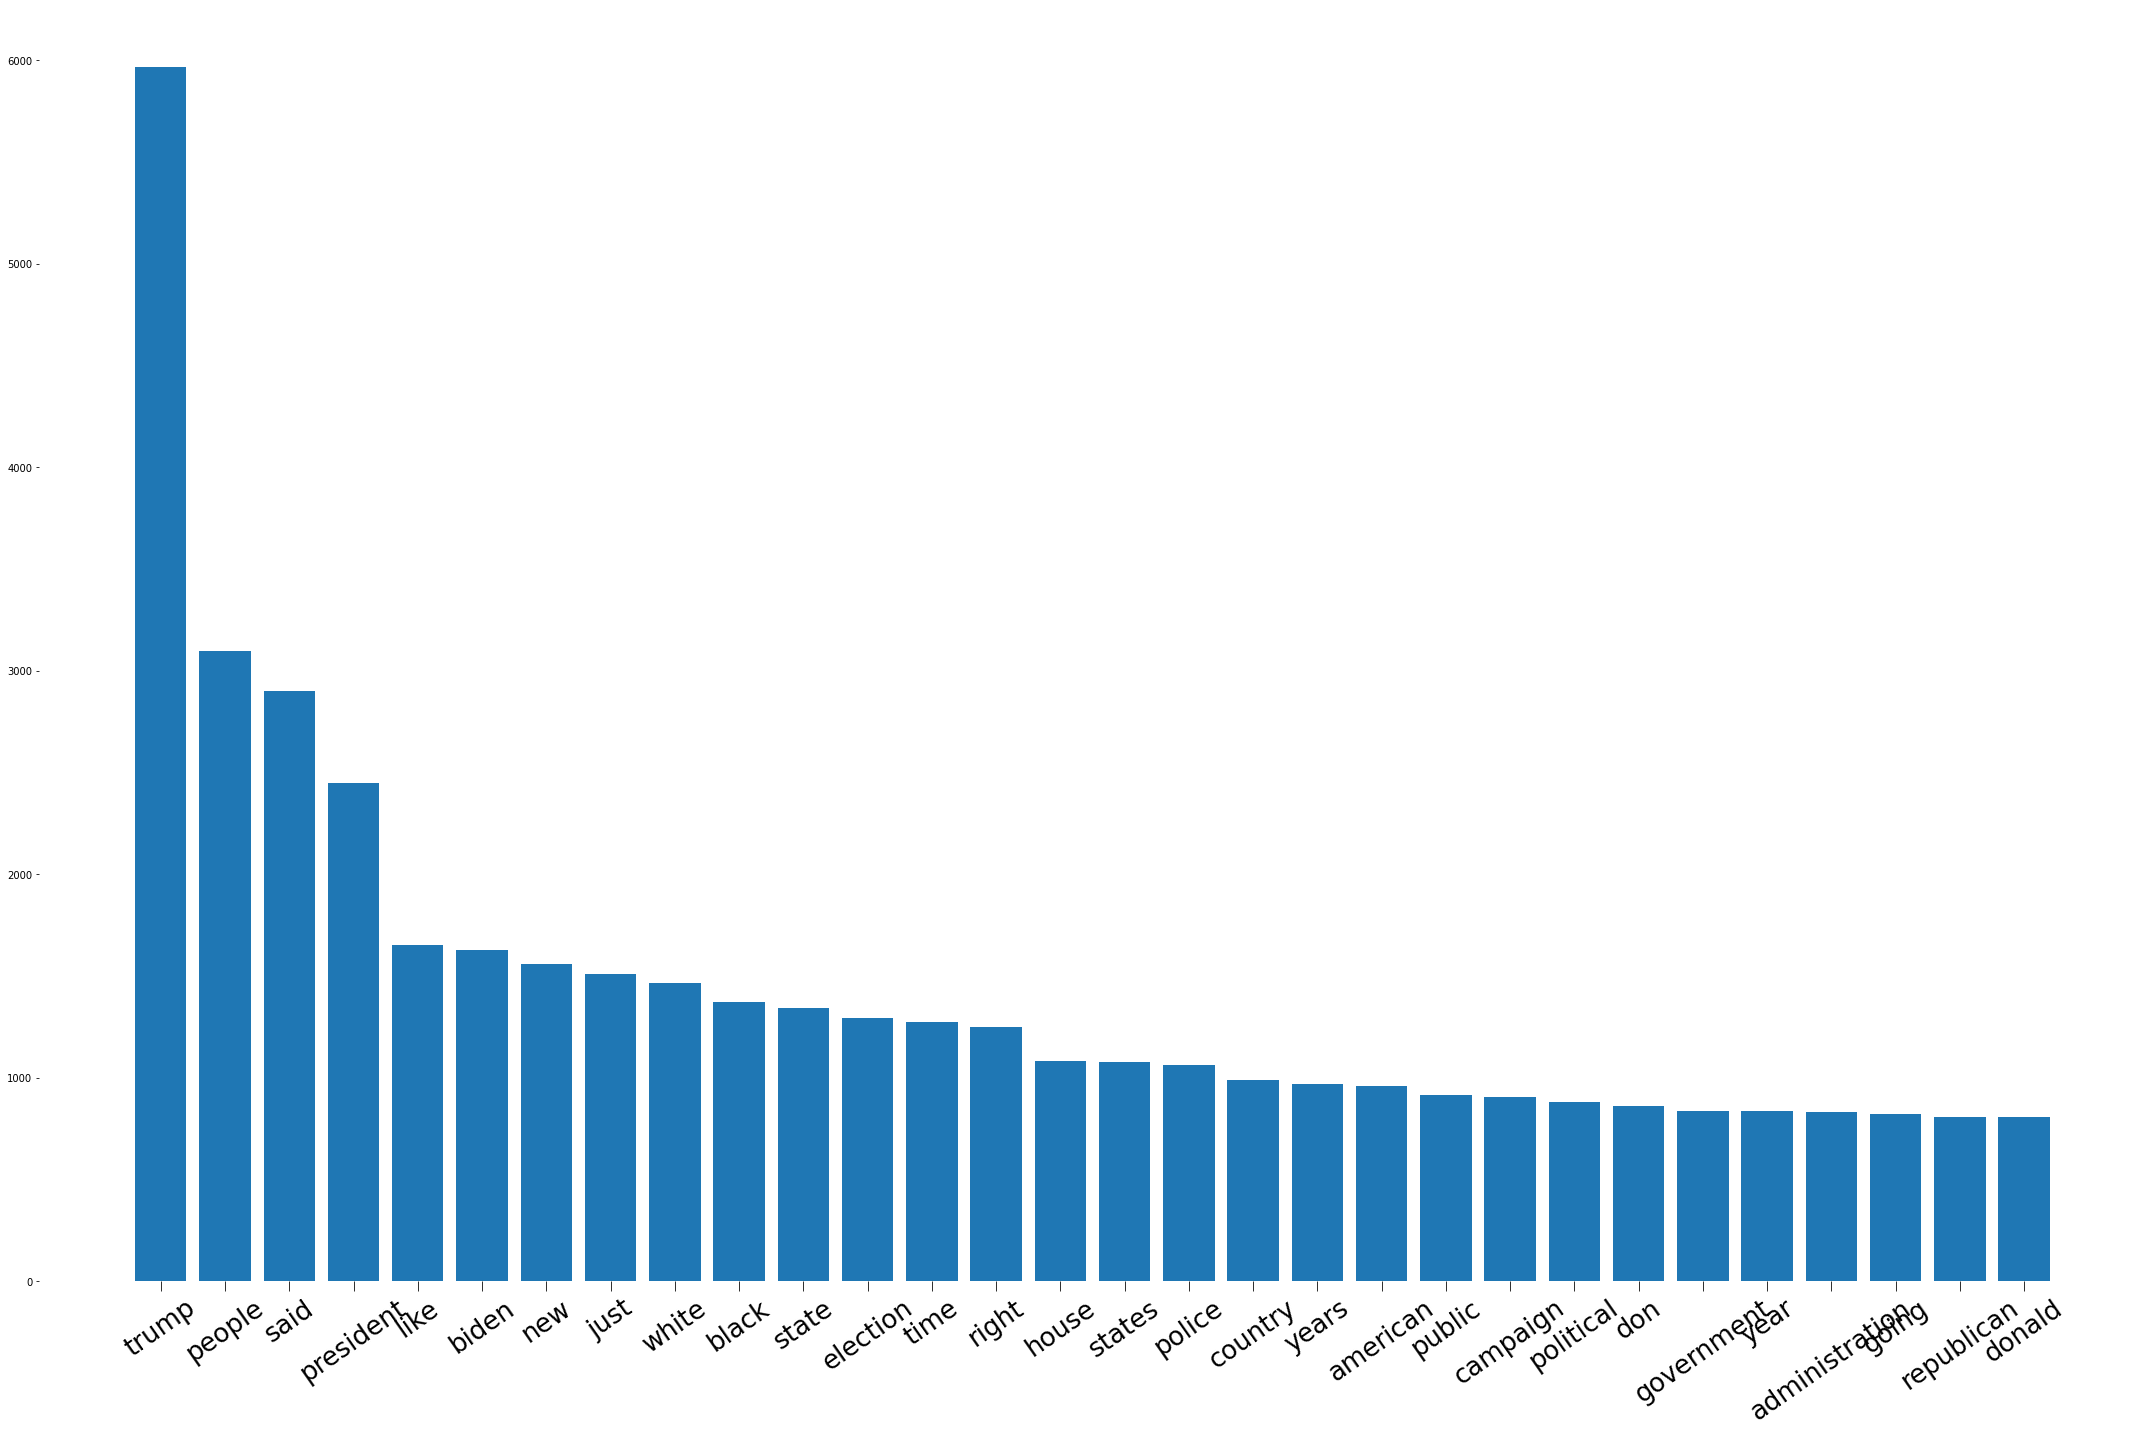

In [ ]:
left_counts = word_counts(df_left,'article_text')
len(left_counts)

30202

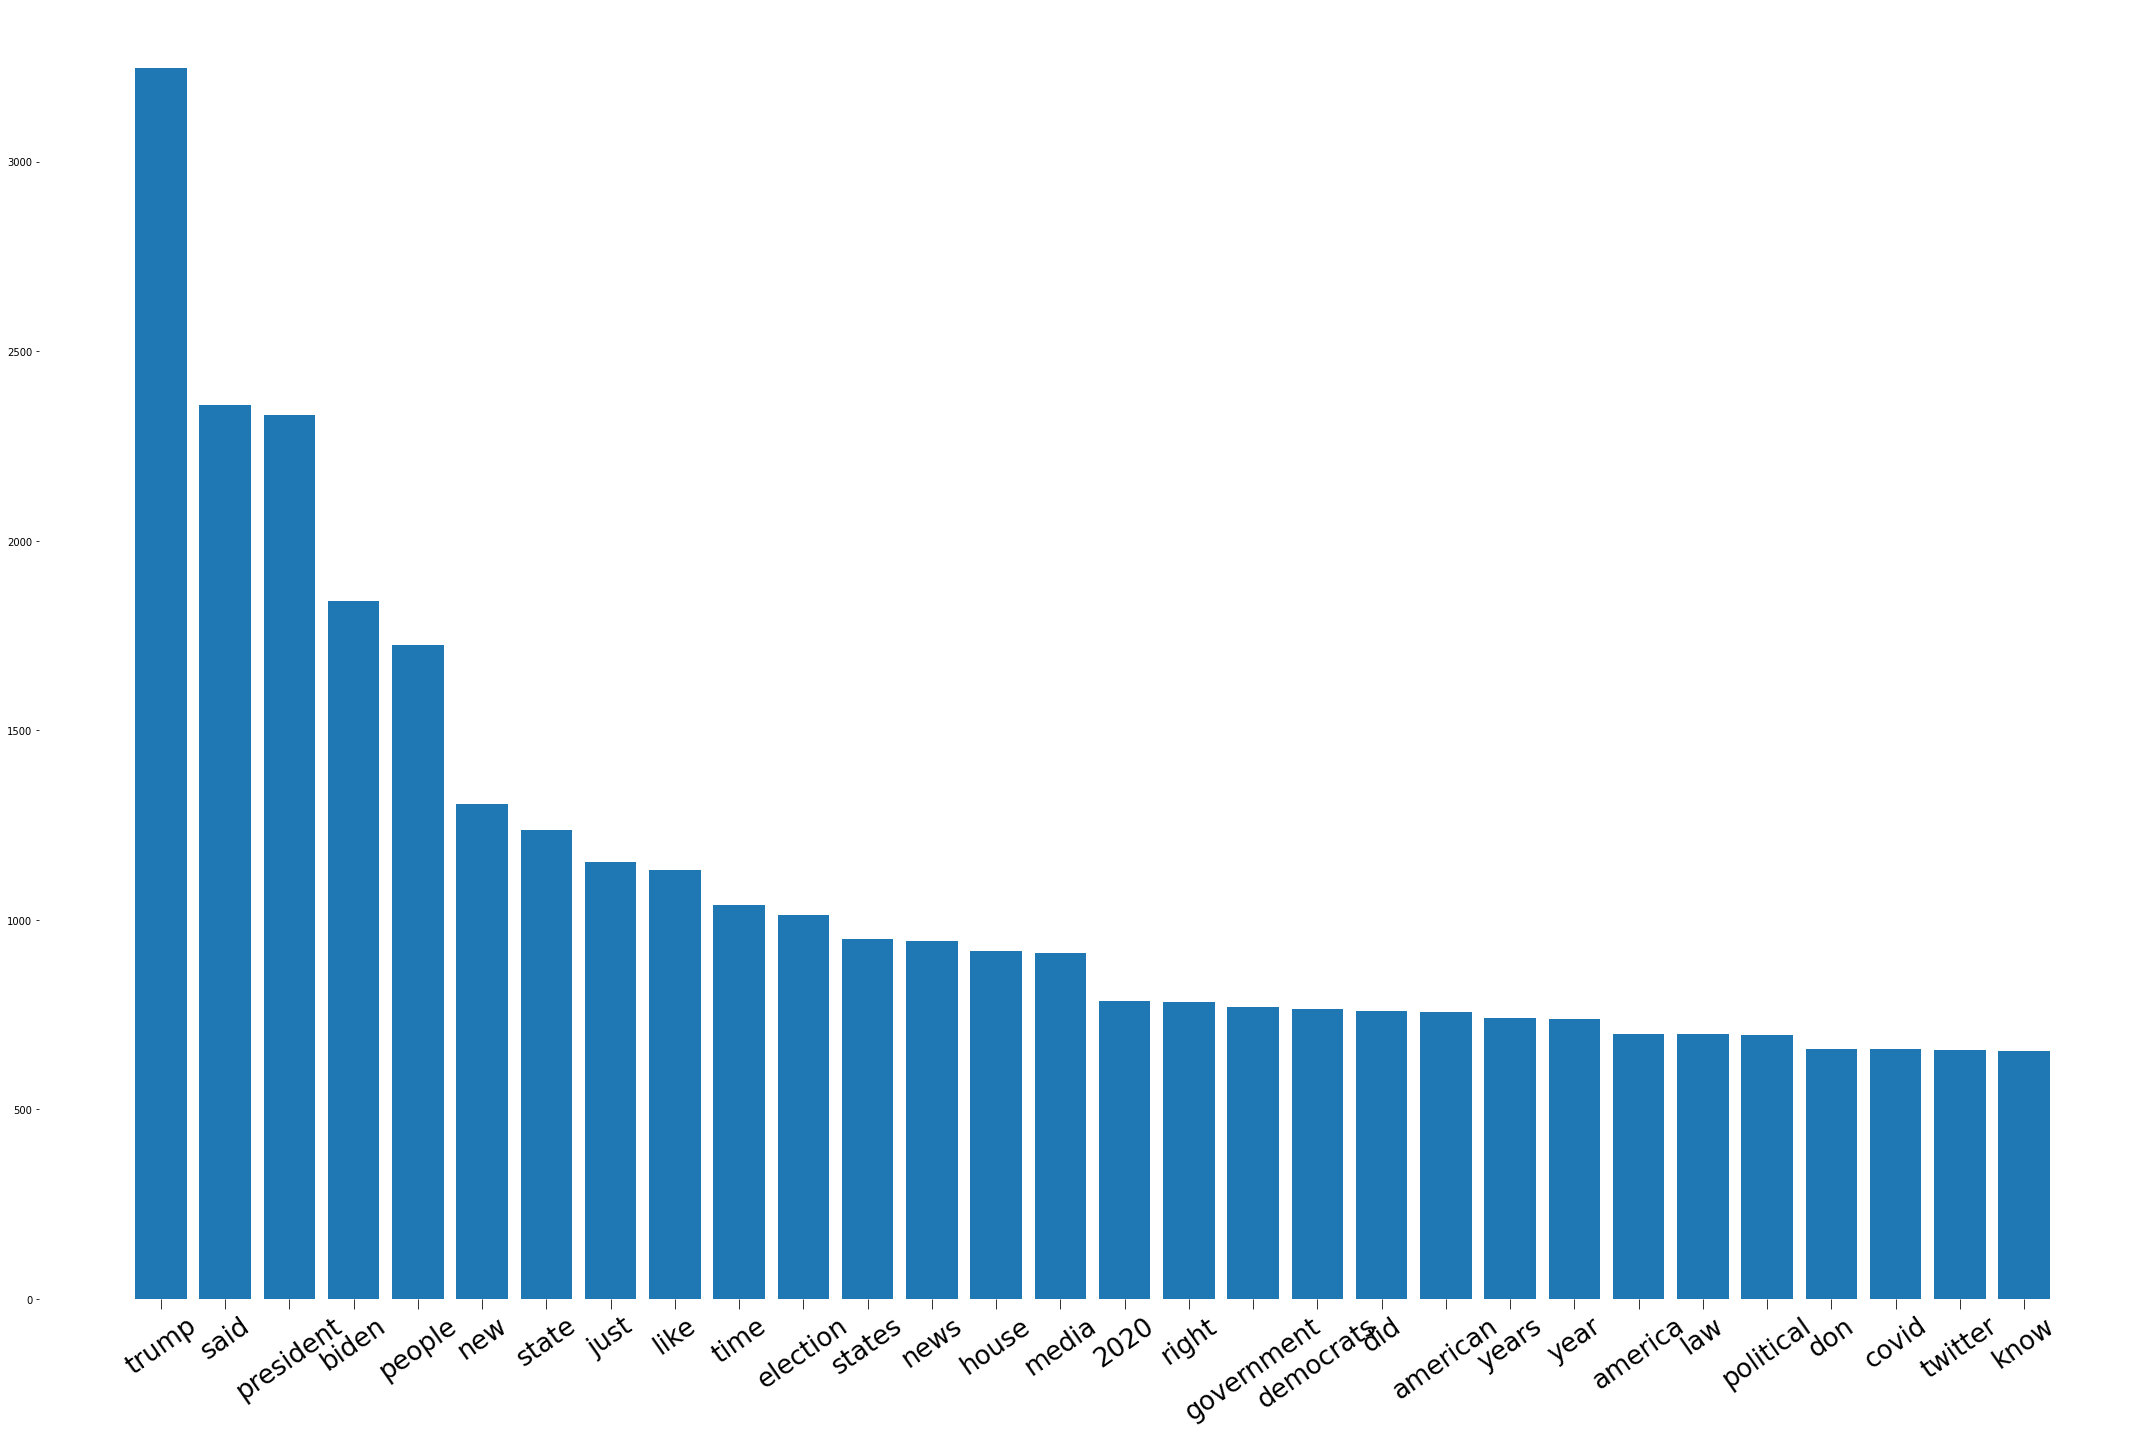

In [ ]:
right_counts = word_counts(df_right,'article_text')
len(right_counts)

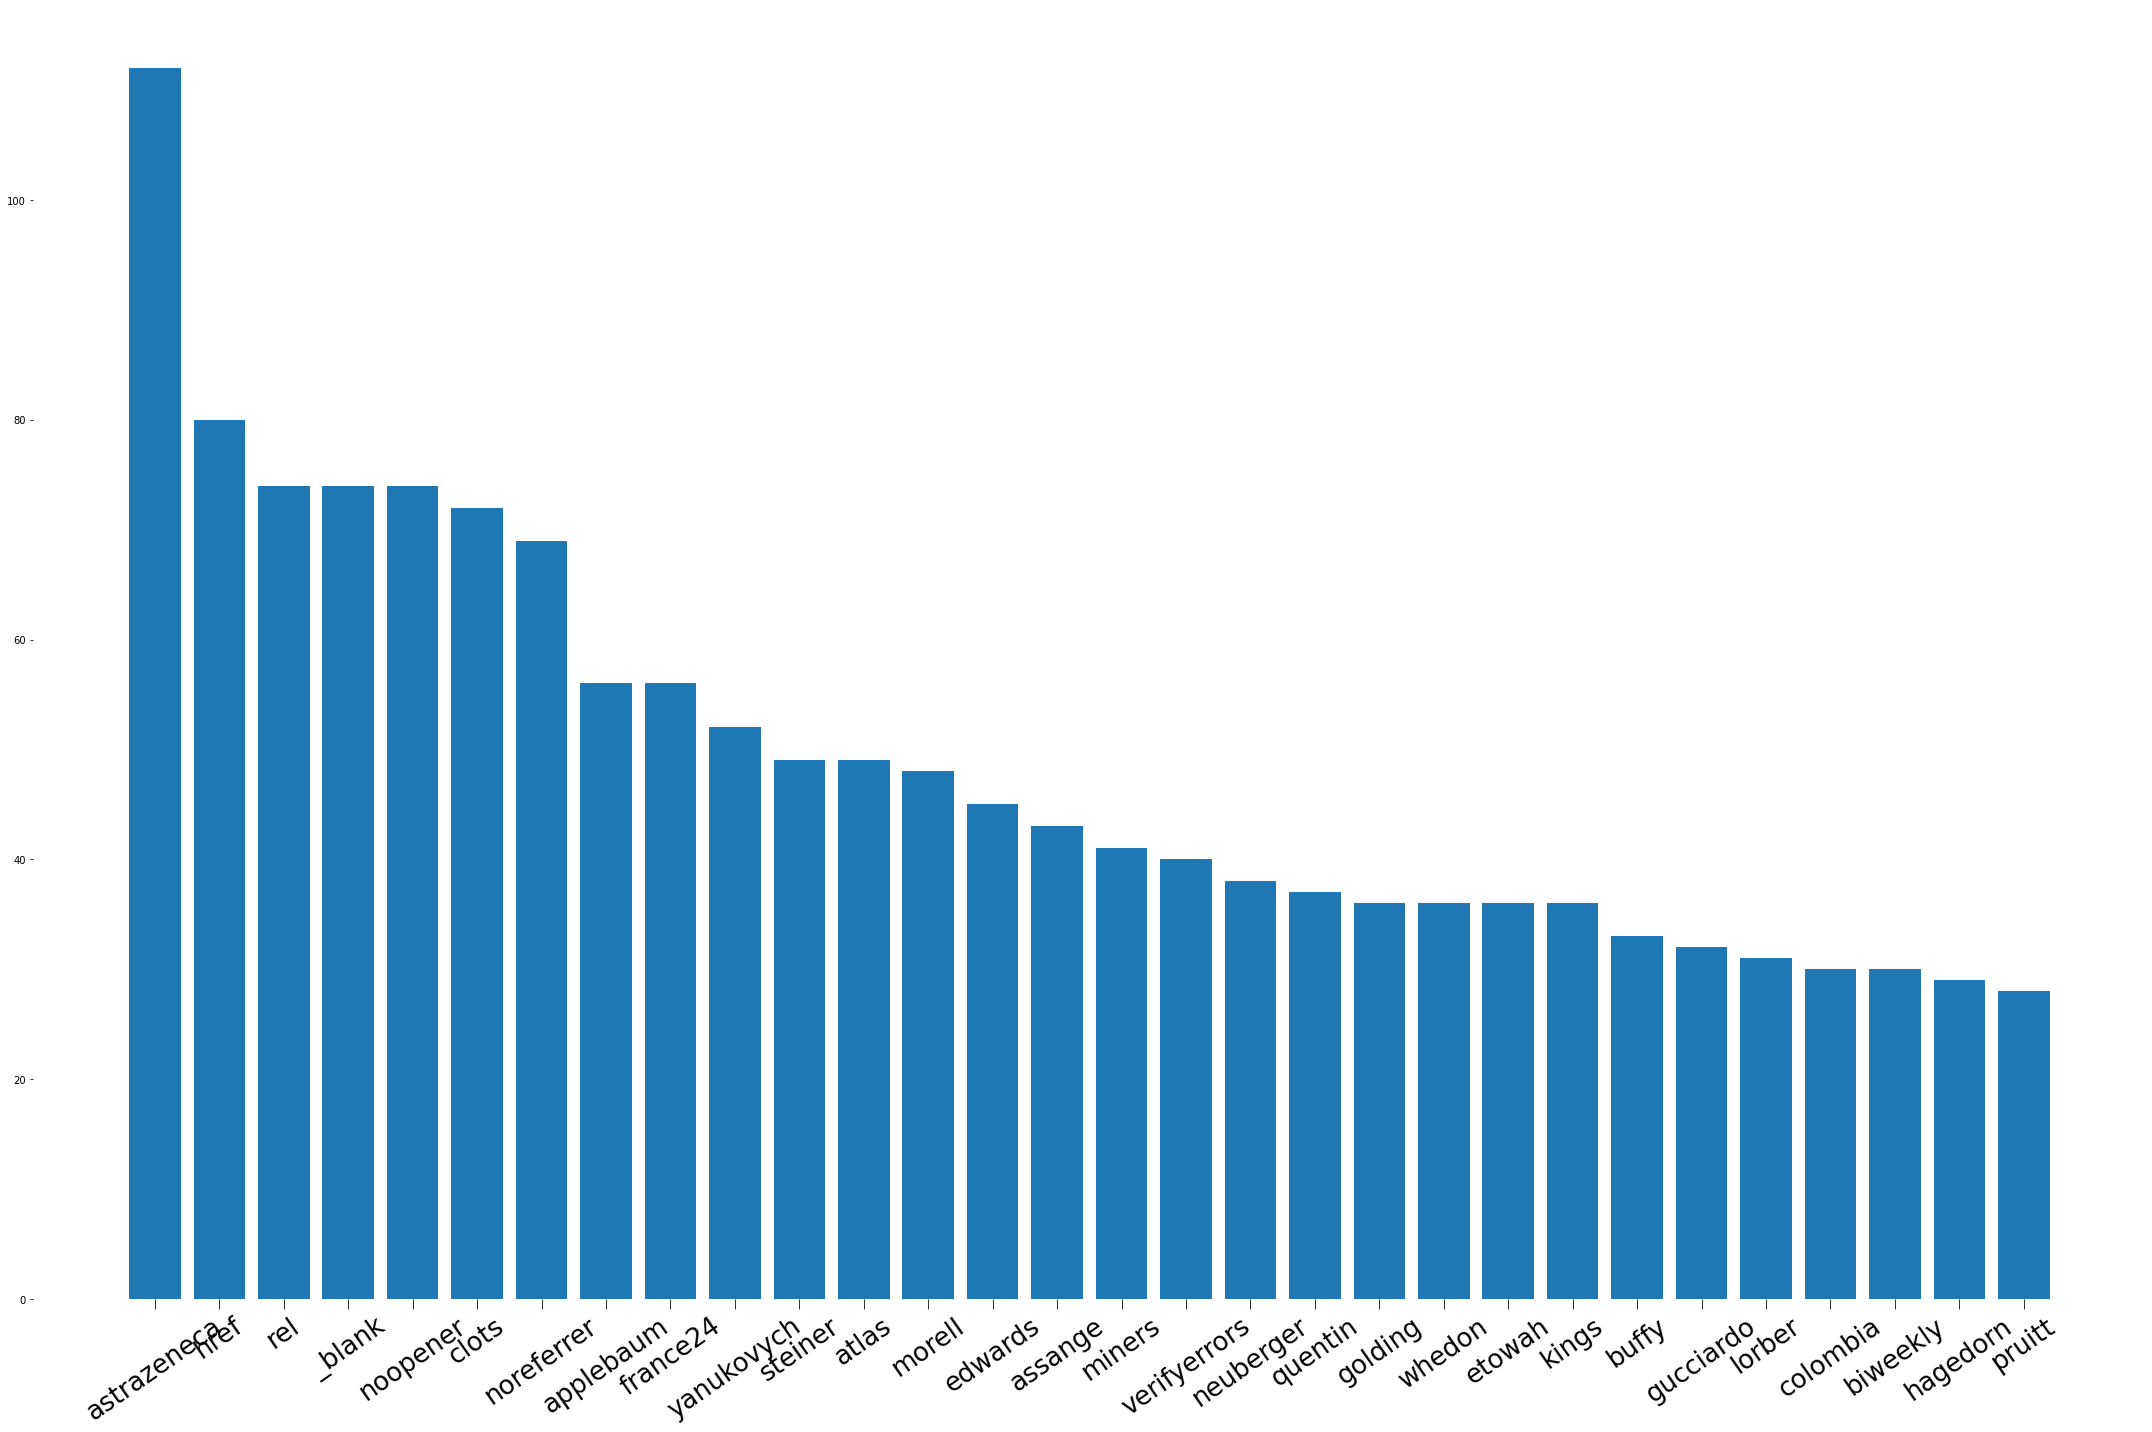

In [ ]:
compare_vocabs(left_counts,right_counts)

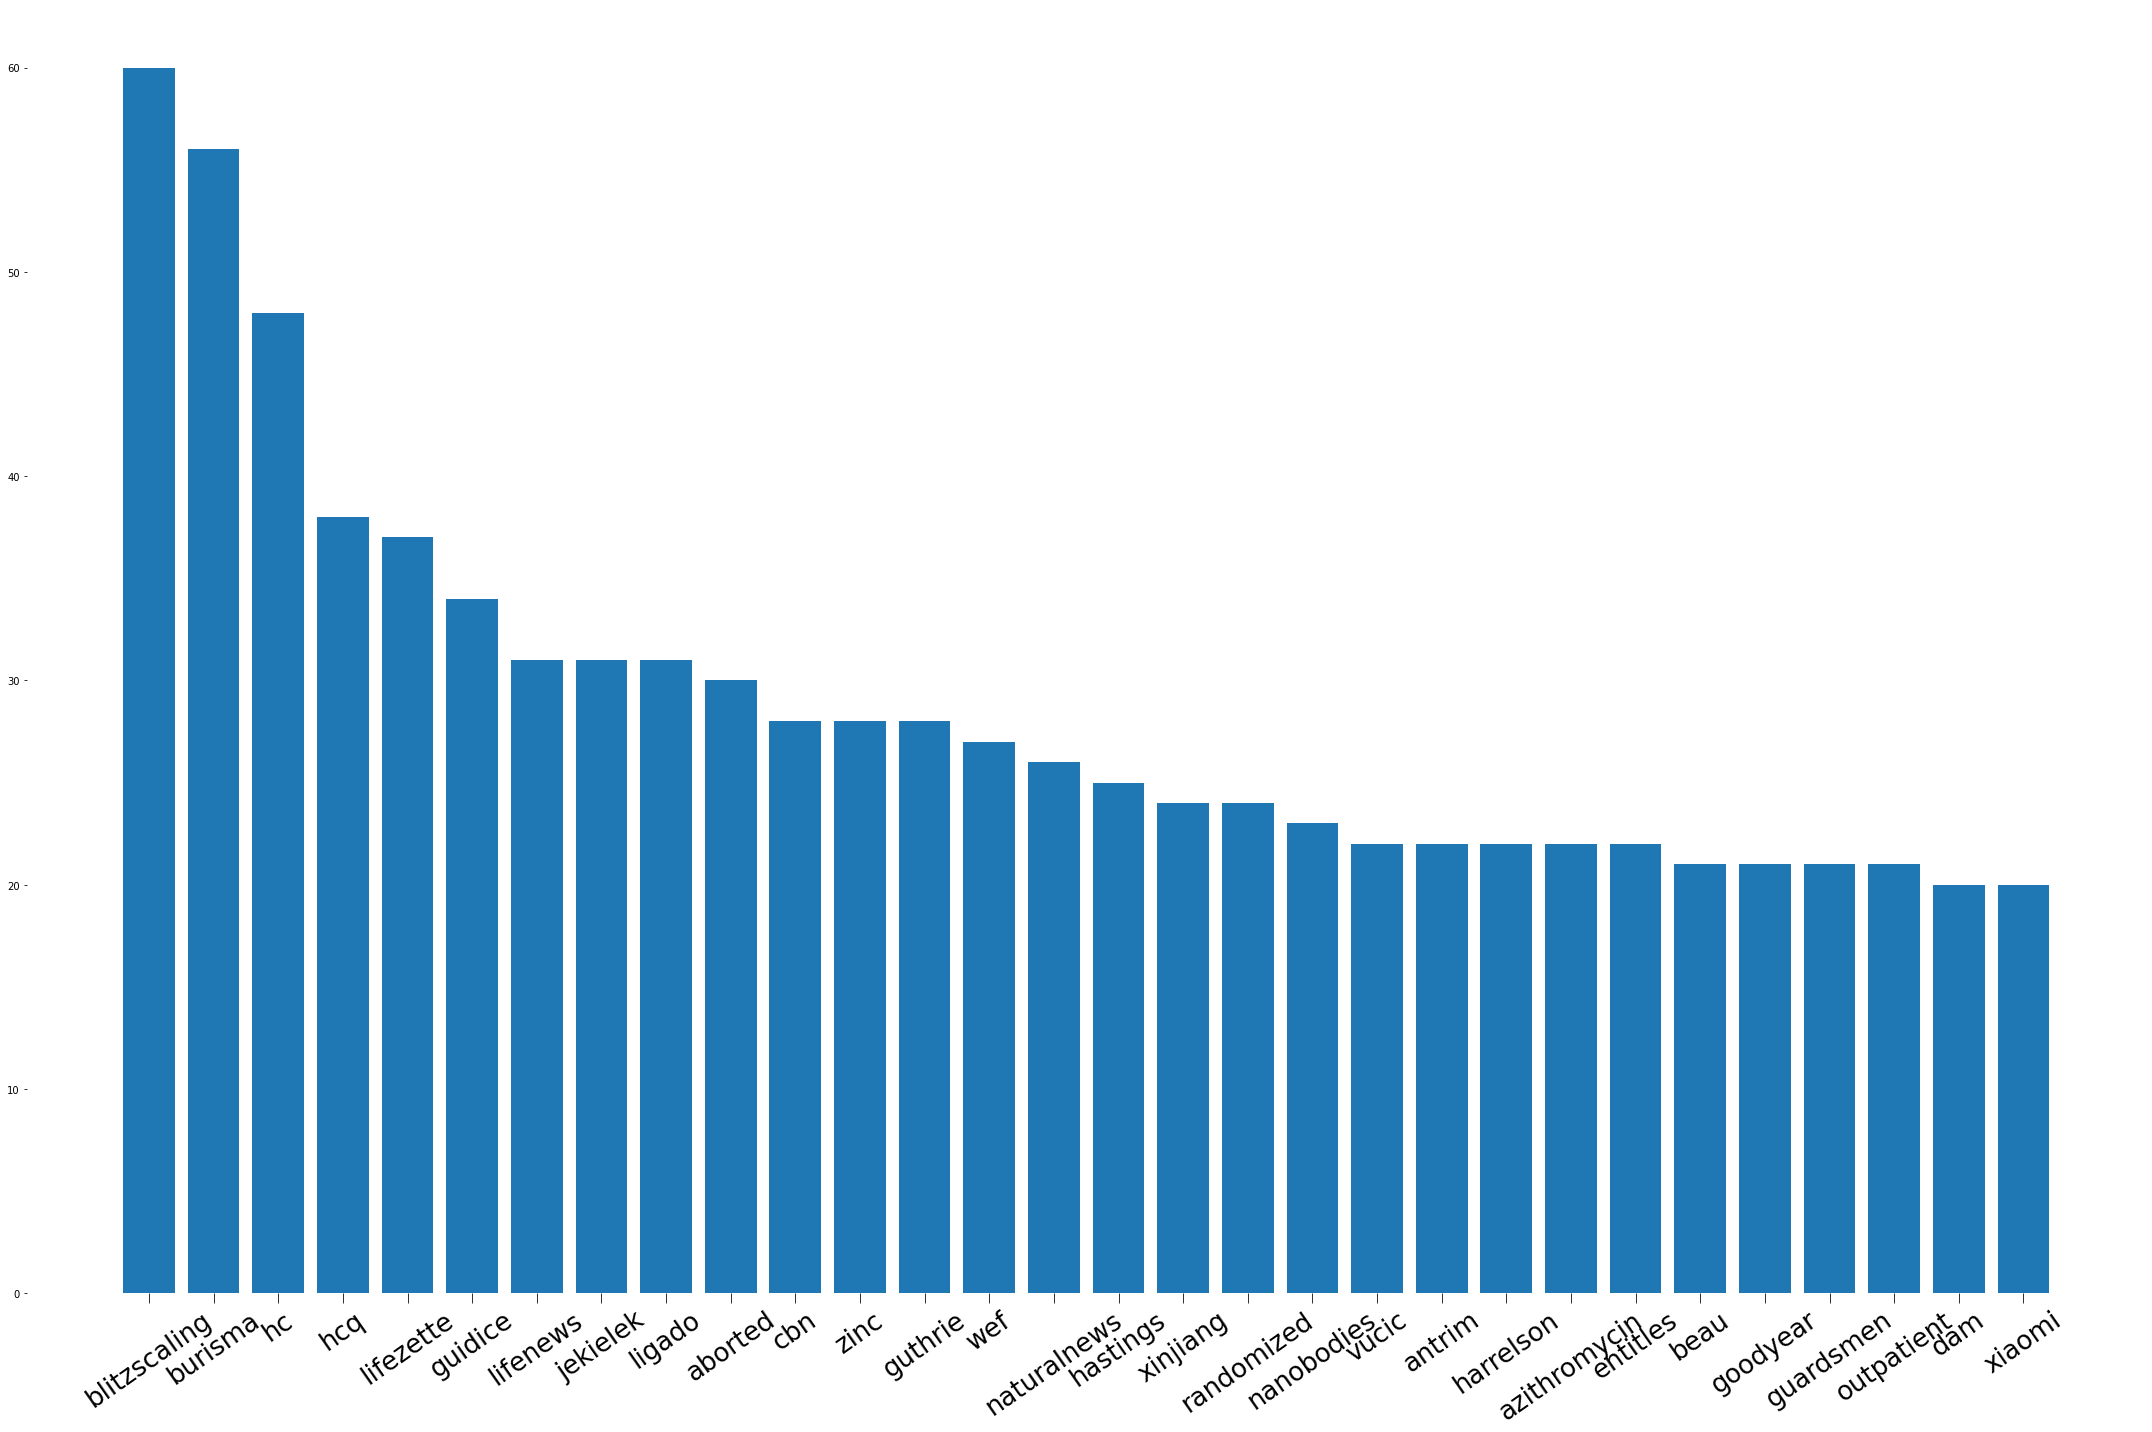

In [ ]:
compare_vocabs(right_counts,left_counts)

In [ ]:
#more context around word occurences? a function that pulls context 
#LDA? 

# Modeling 

## Multinomial Naive Bayes

In [ ]:
df_adf_1 = df_adf[['article_text','article_label']]
df_tmod = TopicModel(
    df_adf_1,
    'article_text',
    stop_words='english',
    vocabulary = vocab, 
    n_topics=30,
    desparsify=True,
    topic_matrix_addback=True
    )


X = df_tmod.data.drop(['article_text','mod_number','article_label'],axis=1)
y = df_tmod.data['article_label']

ref = Refinery(X,y)

info = {
    'description':'base MNB'
}

mnb = Pipeline([
                ('clf', MultinomialNB()),
])

ref.ingest(mnb,info = info)


/content/drive/My Drive/Colab Notebooks/politicalbias/datashop_classes.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['mod_number'] = self.topic_matrix.argmax(axis=1)


,description,f1_score,accuracy,Model
0,base MNB,0.618652,0.61478,MultinomialNB


In [ ]:
df_adf_1 = df_adf[['article_text','article_label']]
df_tmod = TopicModel(
    df_adf_1,
    'article_text',
    stop_words='english',
    vocabulary = vocab, 
    n_topics=30,
    desparsify=True,
    topic_matrix_addback=False
    )


ref.X = df_tmod.data.drop(['article_text','mod_number','article_label'],axis=1)
ref.y = df_tmod.data['article_label']

#ref = Refinery(X,y)

info = {
    'description':'trim vocab but no lda'
}

mnb = Pipeline([
                ('clf', MultinomialNB()),
])

ref.ingest(mnb,info = info)

/content/drive/My Drive/Colab Notebooks/politicalbias/datashop_classes.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['mod_number'] = self.topic_matrix.argmax(axis=1)


,description,f1_score,accuracy,Model
0,base MNB,0.618652,0.614780,MultinomialNB
1,MNB with nmf features,0.337072,0.498786,MultinomialNB
2,MNB with full vocab,0.327506,0.494740,MultinomialNB
3,MNB with nmf features,0.619063,0.615319,MultinomialNB
4,MNB with full vocab & no add back,0.615361,0.615049,MultinomialNB
5,trim vocab but no lda,0.619399,0.615589,MultinomialNB


In [ ]:
df_adf_1 = df_adf[['article_text','article_label']]
df_tmod = TopicModel(
    df_adf_1,
    'article_text',
    stop_words='english', 
    n_topics=30,
    desparsify=True,
    topic_matrix_addback=False
    )


ref.X = df_tmod.data.drop(['article_text','mod_number','article_label'],axis=1)
ref.y = df_tmod.data['article_label']

#ref = Refinery(X,y)

info = {
    'description':'MNB with full vocab & no add back'
}

mnb = Pipeline([
                ('clf', MultinomialNB()),
])

ref.ingest(mnb,info = info)

/content/drive/My Drive/Colab Notebooks/politicalbias/datashop_classes.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['mod_number'] = self.topic_matrix.argmax(axis=1)


,description,f1_score,accuracy,Model
0,base MNB,0.618652,0.614780,MultinomialNB
1,MNB with nmf features,0.337072,0.498786,MultinomialNB
2,MNB with full vocab,0.327506,0.494740,MultinomialNB
3,MNB with nmf features,0.619063,0.615319,MultinomialNB
4,MNB with full vocab & no add back,0.615361,0.615049,MultinomialNB


# SVC

In [ ]:
df_adf_1 = df_adf[['article_text','article_label']]
df_tmod = TopicModel(
    df_adf_1,
    'article_text',
    stop_words='english', 
    n_topics=100,
    vocabulary = vocab,
    desparsify=True,
    topic_matrix_addback=False
    )


ref.X = df_tmod.data.drop(['article_text','mod_number','article_label'],axis=1)
ref.y = df_tmod.data['article_label']

#ref = Refinery(X,y)

info = {
    'description':'MNB with full vocab no add back'
}

mnb = Pipeline([
                ('clf', LinearSVC()),
])

ref.ingest(mnb,info = info)

/content/drive/My Drive/Colab Notebooks/politicalbias/datashop_classes.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['mod_number'] = self.topic_matrix.argmax(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of ite

,description,f1_score,accuracy,Model
0,base MNB,0.618652,0.614780,MultinomialNB
1,MNB with nmf features,0.337072,0.498786,MultinomialNB
2,MNB with full vocab,0.327506,0.494740,MultinomialNB
3,MNB with nmf features,0.619063,0.615319,MultinomialNB
4,MNB with full vocab & no add back,0.615361,0.615049,MultinomialNB
5,trim vocab but no lda,0.619399,0.615589,MultinomialNB
6,MNB with full vocab & no add back,0.610237,0.613444,LinearSVC
7,MNB with full vocab & no add back,0.609118,0.612366,LinearSVC
8,MNB with full vocab no add back,0.608577,0.611826,LinearSVC


In [ ]:
ref = Refinery(X,y)

info = {
    'description':'base KNN'
}

mnb = Pipeline([
                ('clf', MultinomialNB()),
])


ref.ingest(mnb,info = info)

,description,f1_score,accuracy,Model
0,NaN,0.396109,0.523069,MultinomialNB
